In [7]:
using LaTeXStrings
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
;

In [8]:
using HypothesisTests
using Distributions

In [6]:
module KS
    using StatsBase: sample, midpoints
    using Distributions
    using HypothesisTests
    import DeconvolveDistribution

    function decon(X::Vector, σ_X::Vector, bw::Float64, grid::Vector; num_t=50, fixup=true)
        ϵ_distr = Normal.(0.0, σ_X)
        Fhat = DeconvolveDistribution.Fhat(grid, X, num_t, bw, ϵ_distr)
        if fixup
            DeconvolveDistribution.fix_CDF!(Fhat)
        end
        return Fhat
    end
    function cdf_sample(xx, F)
        u = rand() # random uniform
        i = searchsortedfirst(F, u)
        return xx[i]
    end
    function numerical_integration(x, y)
        sum(diff(x) .* midpoints(y))
    end
    function cdf_distance(F_X, F_Y, x, p)
        if p == Inf
            return maximum(abs.(F_X .- F_Y))
        end
        diff_p = abs.(F_X .- F_Y).^p
        return numerical_integration(x, diff_p)^(1/p)
    end
    function distance_test_statistic(p, bw, xgrid)
        function ϕ(X, Y, σ_X, σ_Y)
            F_X_hat = decon(X, σ_X, bw, xgrid)
            F_Y_hat = decon(Y, σ_Y, bw, xgrid)
            return cdf_distance(F_X_hat, F_Y_hat, xgrid, p)
        end
        return ϕ
    end
    function permutation_distrib(X::Vector, Y::Vector, σ_X::Vector, σ_Y::Vector, t::Function; niter=100)
        X_and_Y = cat(1, X, Y)
        t_obs = t(X, Y, σ_X, σ_Y)
        n_X = length(X)
        n_Y = length(Y)
        n_XY = n_X + n_Y
        nabove = 0
        for i in 1:niter
            XY_boot = sample(X_and_Y, n_XY; replace=true)
            Xperm = XY_boot[1:n_X]
            Yperm = XY_boot[n_X+1:end]
            Xtilde = Xperm .+ σ_X.*randn(n_X)
            Ytilde = Yperm .+ σ_Y.*randn(n_Y)
            t_perm = t(Xtilde, Ytilde, σ_X, σ_Y)
            if t_perm > t_obs
                nabove += 1
            end
        end
        return nabove / niter
    end
    function deconv_boot_test(X::Vector, Y::Vector, σ_X::Vector, σ_Y::Vector, t::Function; niter=100)
        X_and_Y = cat(1, X, Y)
        σ_X_and_Y = cat(1, σ_X, σ_Y)
        t_obs = t(X, Y, σ_X, σ_Y)
        n_X = length(X)
        n_Y = length(Y)
        n_XY = n_X + n_Y
        xx = collect(linspace(minimum(X_and_Y)-1.0, maximum(X_and_Y)+1.0, 1000))
        null_CDF = decon(X_and_Y, σ_X_and_Y, 0.3, xx; fixup=true)
        nabove = 0
        for i in 1:niter
            Xboot = [cdf_sample(xx, null_CDF) for _ in 1:n_X]
            Yboot = [cdf_sample(xx, null_CDF) for _ in 1:n_Y]
            Xtilde = Xboot .+ σ_X.*randn(n_X)
            Ytilde = Yboot .+ σ_Y.*randn(n_Y)
            t_perm = t(Xtilde, Ytilde, σ_X, σ_Y)
            if t_perm > t_obs
                nabove += 1
            end
        end
        return nabove / niter
    end
    function deconv_boot_stat(X::Vector, Y::Vector, σ_X::Vector, σ_Y::Vector, t::Function; niter=100)
        X_and_Y = cat(1, X, Y)
        σ_X_and_Y = cat(1, σ_X, σ_Y)
        t_obs = t(X, Y, σ_X, σ_Y)
        n_X = length(X)
        n_Y = length(Y)
        n_XY = n_X + n_Y
        t_record = Vector{typeof(t_obs)}(niter)
        xx = collect(linspace(minimum(X_and_Y)-1.0, maximum(X_and_Y)+1.0, 1000))
        null_CDF = decon(X_and_Y, σ_X_and_Y, 0.3, xx; fixup=true)
        nabove = 0
        for i in 1:niter
            Xboot = [cdf_sample(xx, null_CDF) for _ in 1:n_X]
            Yboot = [cdf_sample(xx, null_CDF) for _ in 1:n_Y]
            Xtilde = Xboot .+ σ_X.*randn(n_X)
            Ytilde = Yboot .+ σ_Y.*randn(n_Y)
            t_perm = t(Xtilde, Ytilde, σ_X, σ_Y)
            t_record[i] = t_perm
        end
        return t_record
    end
    function sim(F_X::Distribution, F_Y::Distribution, σ_X_distr::Distribution, σ_Y_distr::Distribution, n_X::Int, n_Y::Int, t::Function; kwargs...)
        σ_X = rand(σ_X_distr, n_X)
        σ_Y = rand(σ_Y_distr, n_Y)
        X = rand(F_X, n_X)
        Y = rand(F_Y, n_Y)
        Xtilde = X .+ σ_X .* randn(n_X)
        Ytilde = Y .+ σ_Y .* randn(n_Y)
        permutation_distrib(Xtilde, Ytilde, σ_X, σ_Y, t; kwargs...)
    end
    function sim_deconv(F_X::Distribution, F_Y::Distribution, σ_X_distr::Distribution, σ_Y_distr::Distribution, n_X::Int, n_Y::Int, t::Function; kwargs...)
        σ_X = rand(σ_X_distr, n_X)
        σ_Y = rand(σ_Y_distr, n_Y)
        X = rand(F_X, n_X)
        Y = rand(F_Y, n_Y)
        Xtilde = X .+ σ_X .* randn(n_X)
        Ytilde = Y .+ σ_Y .* randn(n_Y)
        deconv_boot_test(Xtilde, Ytilde, σ_X, σ_Y, t; kwargs...)
    end
    function Luis_cheating_boot_test(Xtilde, Ytilde, σ_X, σ_Y; niter=100)
        X_and_Y = cat(1, Xtilde, Ytilde)
        σ_X_and_Y = cat(1, σ_X, σ_Y)
        
        n_X = length(Xtilde)
        n_Y = length(Ytilde)
        n_XY = n_X + n_Y
        xx = collect(linspace(minimum(X_and_Y)-1.0, maximum(X_and_Y)+1.0, 1000))
        null_CDF = decon(X_and_Y, σ_X_and_Y, 0.3, xx; fixup=true)
        F_X_hat = decon(Xtilde, σ_X, 0.3, xx; fixup=true)
        F_Y_hat = decon(Ytilde, σ_Y, 0.3, xx; fixup=true)
        ϕ_obs = cdf_distance(F_X_hat, F_Y_hat, xx, Inf)
        ϕ_record = Vector{Float64}(niter)
        
        nabove = 0
        for i in 1:niter
            Xboot = [cdf_sample(xx, null_CDF) for _ in 1:n_X]
            Yboot = [cdf_sample(xx, null_CDF) for _ in 1:n_Y]
            Xtilde = Xboot .+ 0.01.*randn(n_X)
            Ytilde = Yboot .+ 0.01.*randn(n_Y)
            ϕ_boot = HypothesisTests.ApproximateTwoSampleKSTest(Xtilde, Ytilde).δ
            if ϕ_boot > ϕ_obs
                nabove += 1
            end
            ϕ_record[i] = ϕ_boot
        end
        return Dict(
            :pvalue => nabove / niter, 
            :obs => ϕ_obs, 
            :bootstrapped => ϕ_record
            )
    end
    function Luis_cheating_sim(F_X::Distribution, F_Y::Distribution, σ_X_distr::Distribution, σ_Y_distr::Distribution, n_X::Int, n_Y::Int; kwargs...)
        σ_X = rand(σ_X_distr, n_X)
        σ_Y = rand(σ_Y_distr, n_Y)
        X = rand(F_X, n_X)
        Y = rand(F_Y, n_Y)
        Xtilde = X .+ σ_X .* randn(n_X)
        Ytilde = Y .+ σ_Y .* randn(n_Y)
        Luis_cheating_boot_test(Xtilde, Ytilde, σ_X, σ_Y; kwargs...)
    end
end

KS

# Luis Experiment

In [8]:
@time pvalues_Luis = let
    n_X = 100
    n_Y = 150
    pvalues_Luis = [
        KS.Luis_cheating_sim( # perform a single simulation
            Normal(0.0, 2.0), Normal(0.0, 2.0),
            Gamma(2.0, 1.0), Gamma(2.0, 2.0), 
            n_X, n_Y; 
            niter=500 # number of *bootstrap* samples
            )[:pvalue]
        for _ in 1:500]
    pvalues_Luis
end
;

392.343479 seconds (27.23 M allocations: 10.926 GiB, 0.38% gc time)


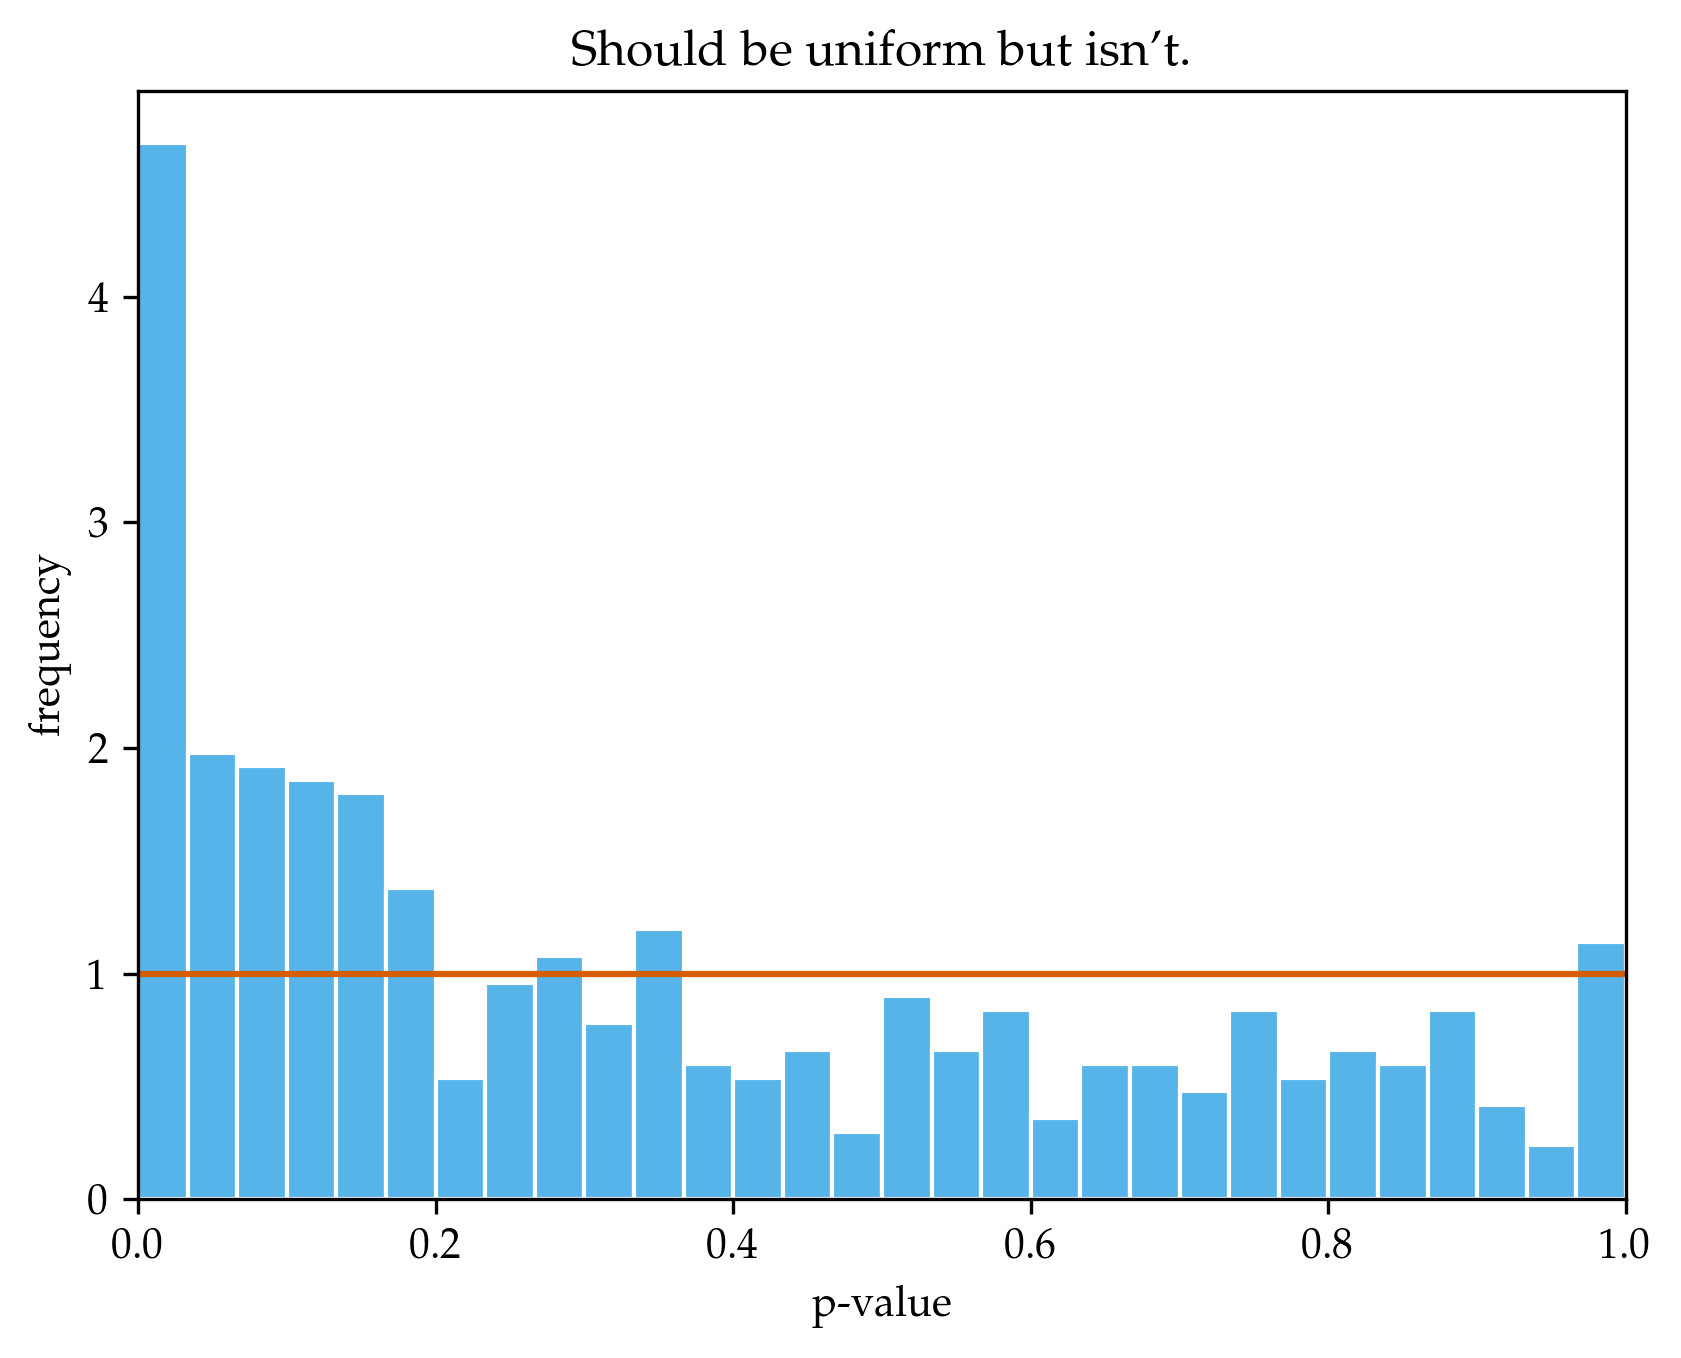

In [9]:
plt.plt[:hist](pvalues_Luis, bins=30, color=cbbPalette[2], normed=true, edgecolor="white")
plt.axhline(1.0, color=cbbPalette[6])
plt.xlabel("p-value")
plt.ylabel("frequency")
plt.title("Should be uniform but isn't.")
plt.xlim(0, 1)
;

# Simulate some data

In [4]:
# using a module as a cheap way to encapsulate variables
module sim
    using Distributions
    F_X = Normal(0, 2)
    F_X = MixtureModel([Normal(-2, 1), Normal(2, 1)], [0.4, 0.6])
    F_Y = Normal(0, 2)
    n_X = 200
    n_Y = 120
    σ_distr = Gamma(2.0, 1.0)
    σ = rand(σ_distr, n_X)
    γ = rand(σ_distr, n_Y)
    X = rand(F_X, n_X)
    Y = rand(F_Y, n_Y)
    Xtilde = X .+ σ .* randn(n_X)
    Ytilde = Y .+ γ .* randn(n_Y)
end

sim

In [53]:
xx = linspace(0, 10, 100)
plt.plot(xx, pdf.(Gamma(2.0, 1.0), xx))
plt.plot(xx, pdf.(Gamma(2.0, 2.0), xx))
plt.title(L"Distributions of $\sigma_X$ and $\sigma_Y$ used in simulations")

# Testing deconvolution and sampling

In [10]:
xx = collect(linspace(minimum(sim.Xtilde)-3.0, maximum(sim.Xtilde)+3.0, 1000))
F = KS.decon(sim.Xtilde, sim.σ, 0.3, xx; num_t=200, fixup=true)
F_samples = [KS.cdf_sample(xx, F) for _ in 1:1000000]
F_samples[1:10]
;

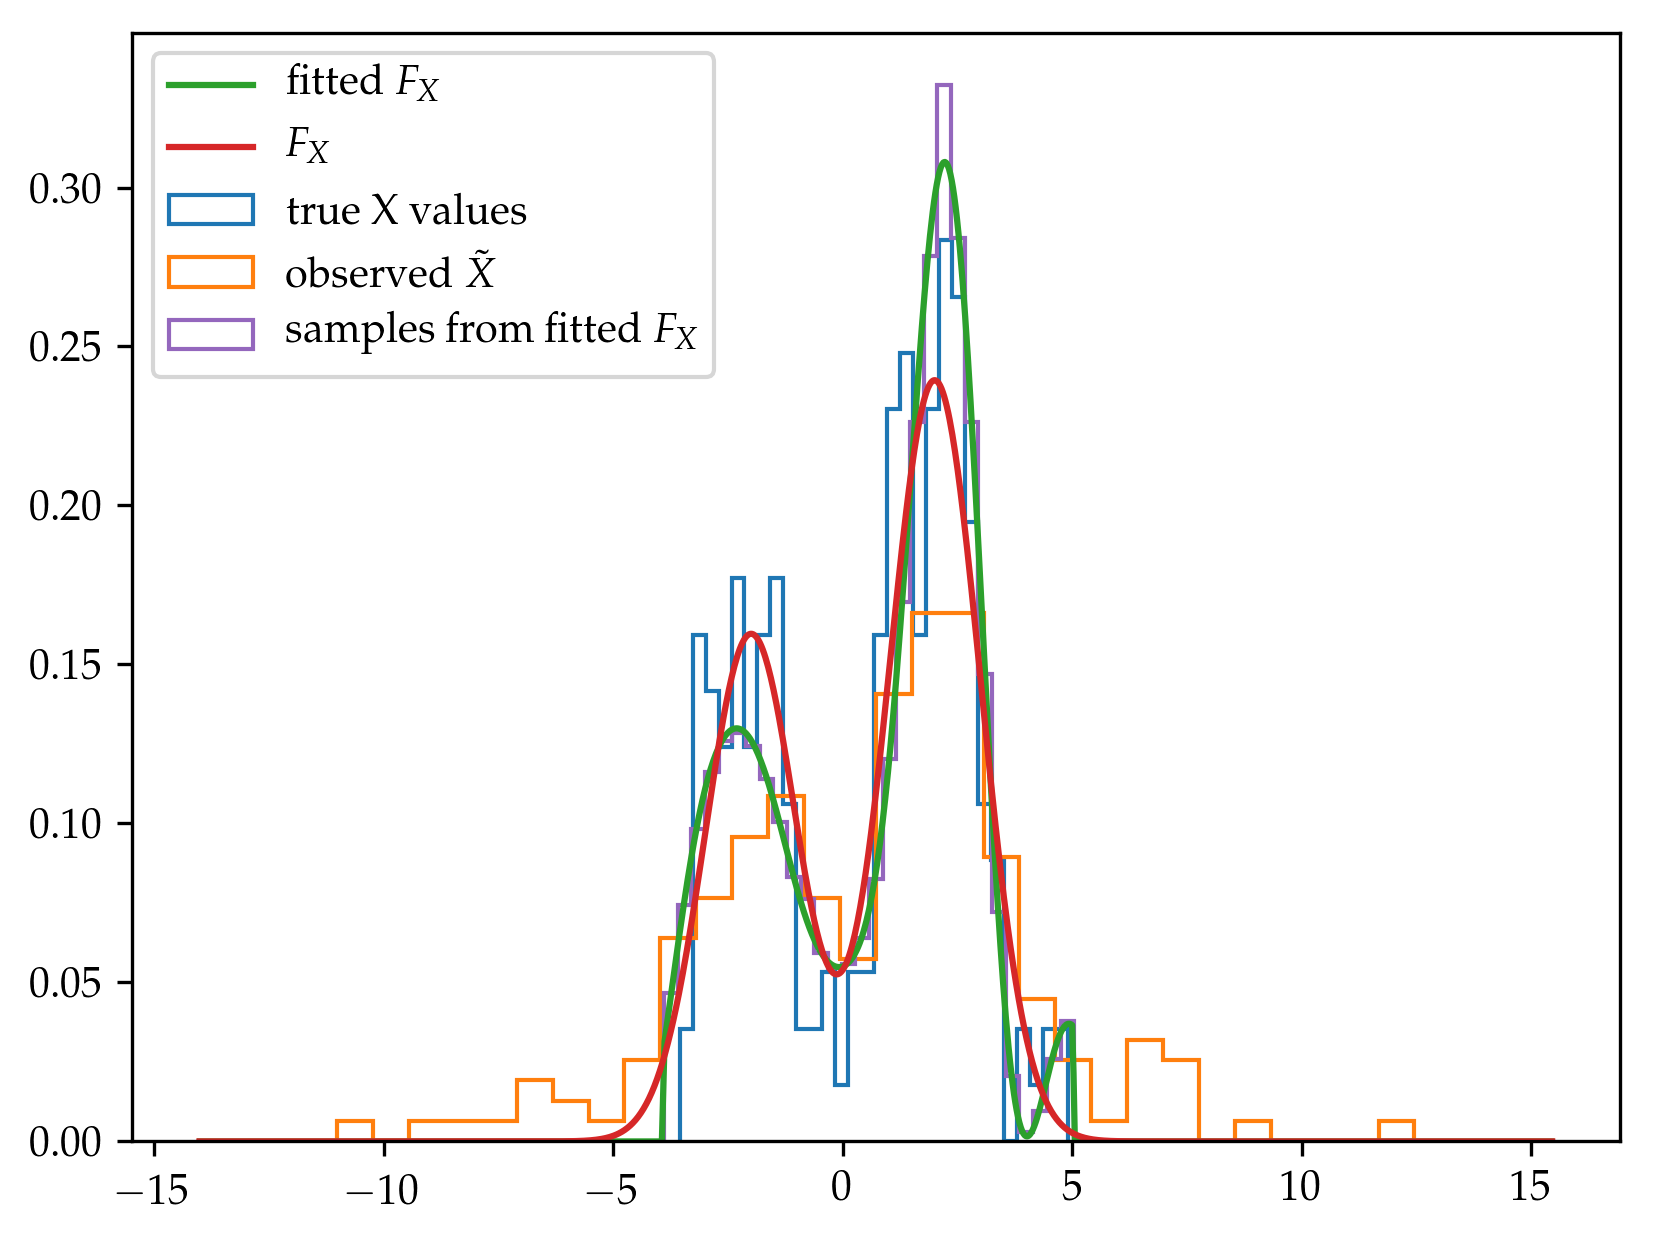

In [13]:
plt.plt[:hist](sim.X, histtype="step", normed=true, bins=30, label="true X values")
plt.plt[:hist](sim.Xtilde, histtype="step", normed=true, bins=30, label=L"observed $\tilde{X}$")
plt.plot(StatsBase.midpoints(xx), diff(F)./diff(xx), label=L"fitted $F_X$")
plt.plot(xx, pdf.(sim.F_X, xx), label=L"F_X")
plt.plt[:hist](F_samples, histtype="step", bins=30, normed=true, label=L"samples from fitted $F_X$")
plt.legend(loc="upper left")
;

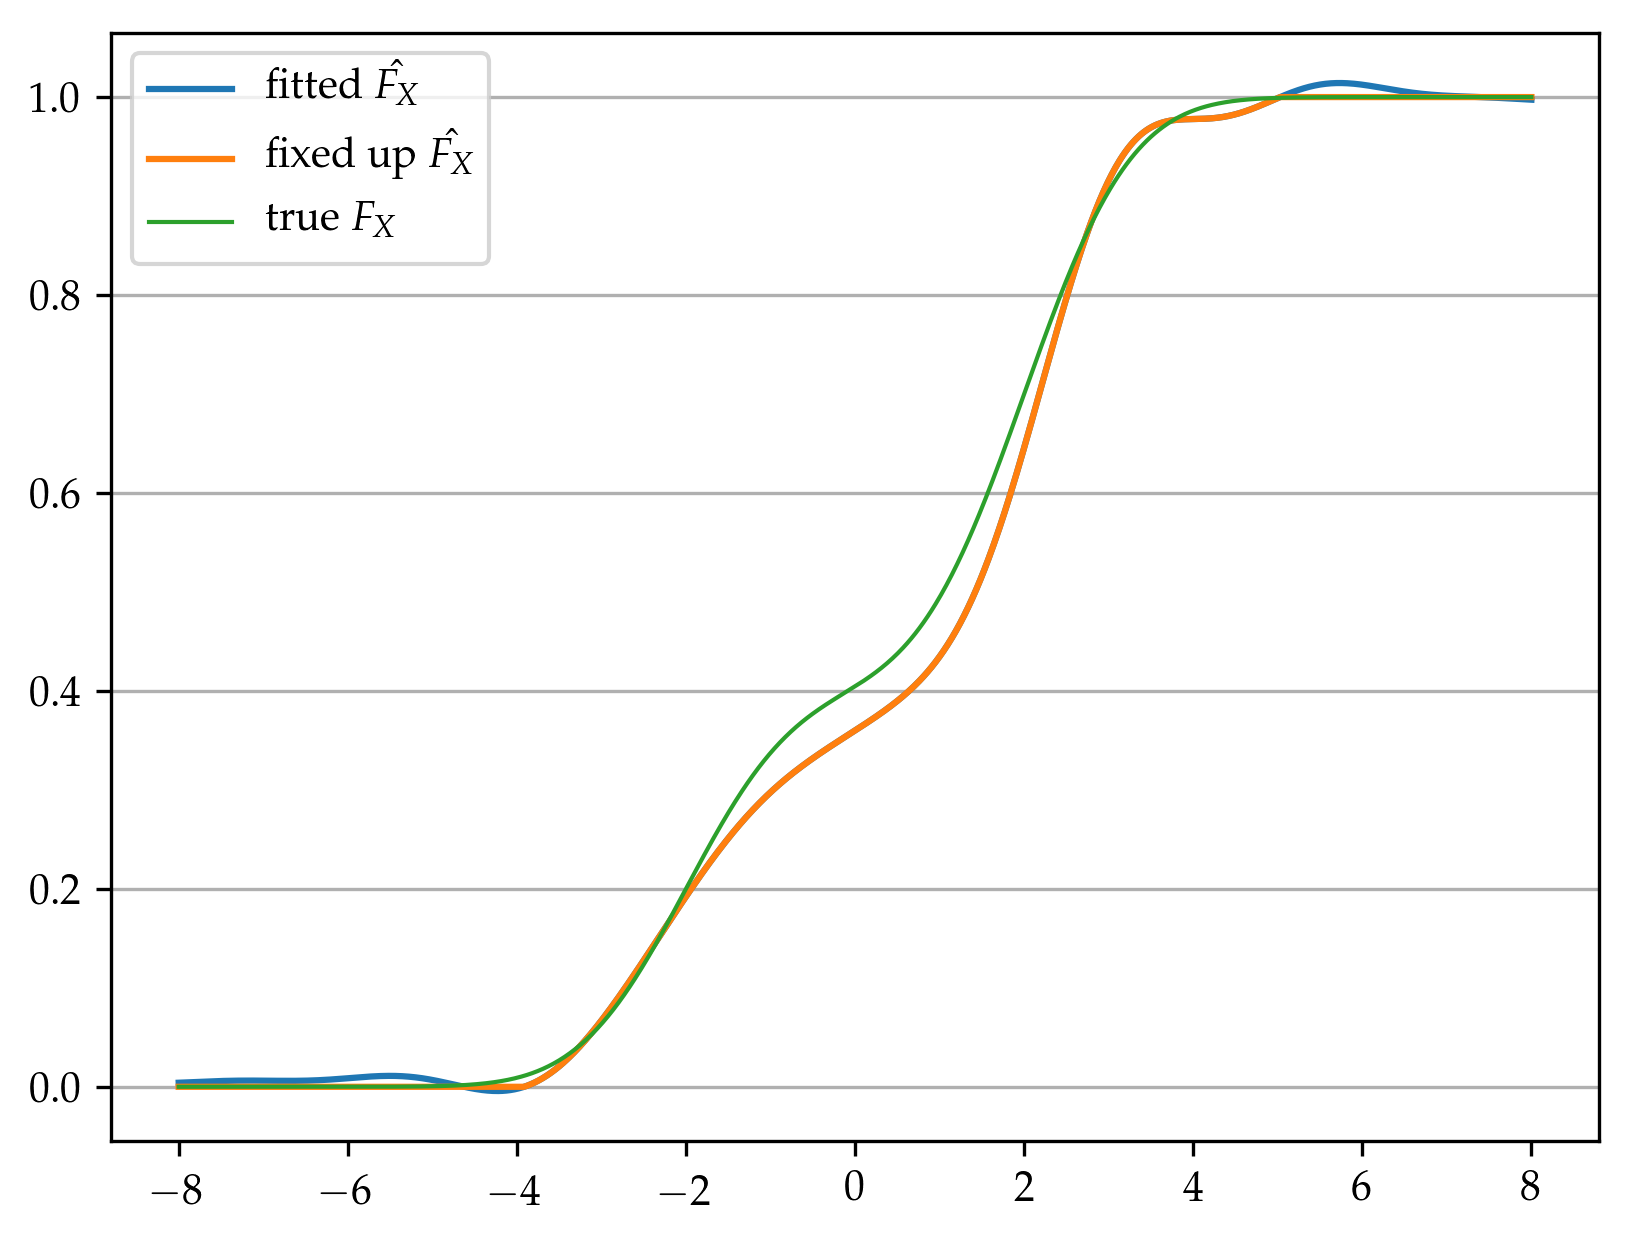

(0.0, 1.0)

In [15]:
xx = collect(linspace(-8.0, 8.0, 1000))
Fhat_nofix = KS.decon(sim.Xtilde, sim.σ, 0.3, xx; num_t=100, fixup=false)
Fhat = KS.decon(sim.Xtilde, sim.σ, 0.3, xx; fixup=true)

plt.plot(xx, Fhat_nofix, label=L"fitted $\hat{F_X}$")
plt.plot(xx, Fhat, label=L"fixed up $\hat{F_X}$")
plt.plot(xx, cdf.(sim.F_X, xx), linewidth=1, label=L"true $F_X$")
plt.legend(loc="upper left")
plt.grid(axis="y")
# plt.xlim(4.0, 6.0)
# plt.ylim(0.95, 1.05)
extrema(Fhat)

In [18]:
t_KS = (x, y, σ_x, σ_y) -> HypothesisTests.ApproximateTwoSampleKSTest(x, y).δ
KS.permutation_distrib(sim.Xtilde, sim.Ytilde, sim.σ, sim.γ, t_KS; niter=10000)

0.1003

In [22]:
KS.sim(
    Normal(0, 2), Normal(0, 2), 
    Gamma(2.0, 1.0), Gamma(2.0, 2.0), 
    sim.n_X, sim.n_Y, t_KS; 
    niter=200)

0.535

In [23]:
null_pvals_KS = [
    KS.sim(
        Normal(0.0, 2.0), Normal(0.0, 2.0),
        Gamma(2.0, 1.0), Gamma(2.0, 2.0), 
        sim.n_X, sim.n_Y, t_KS; 
        niter=400
        ) 
    for _ in 1:1000]
;

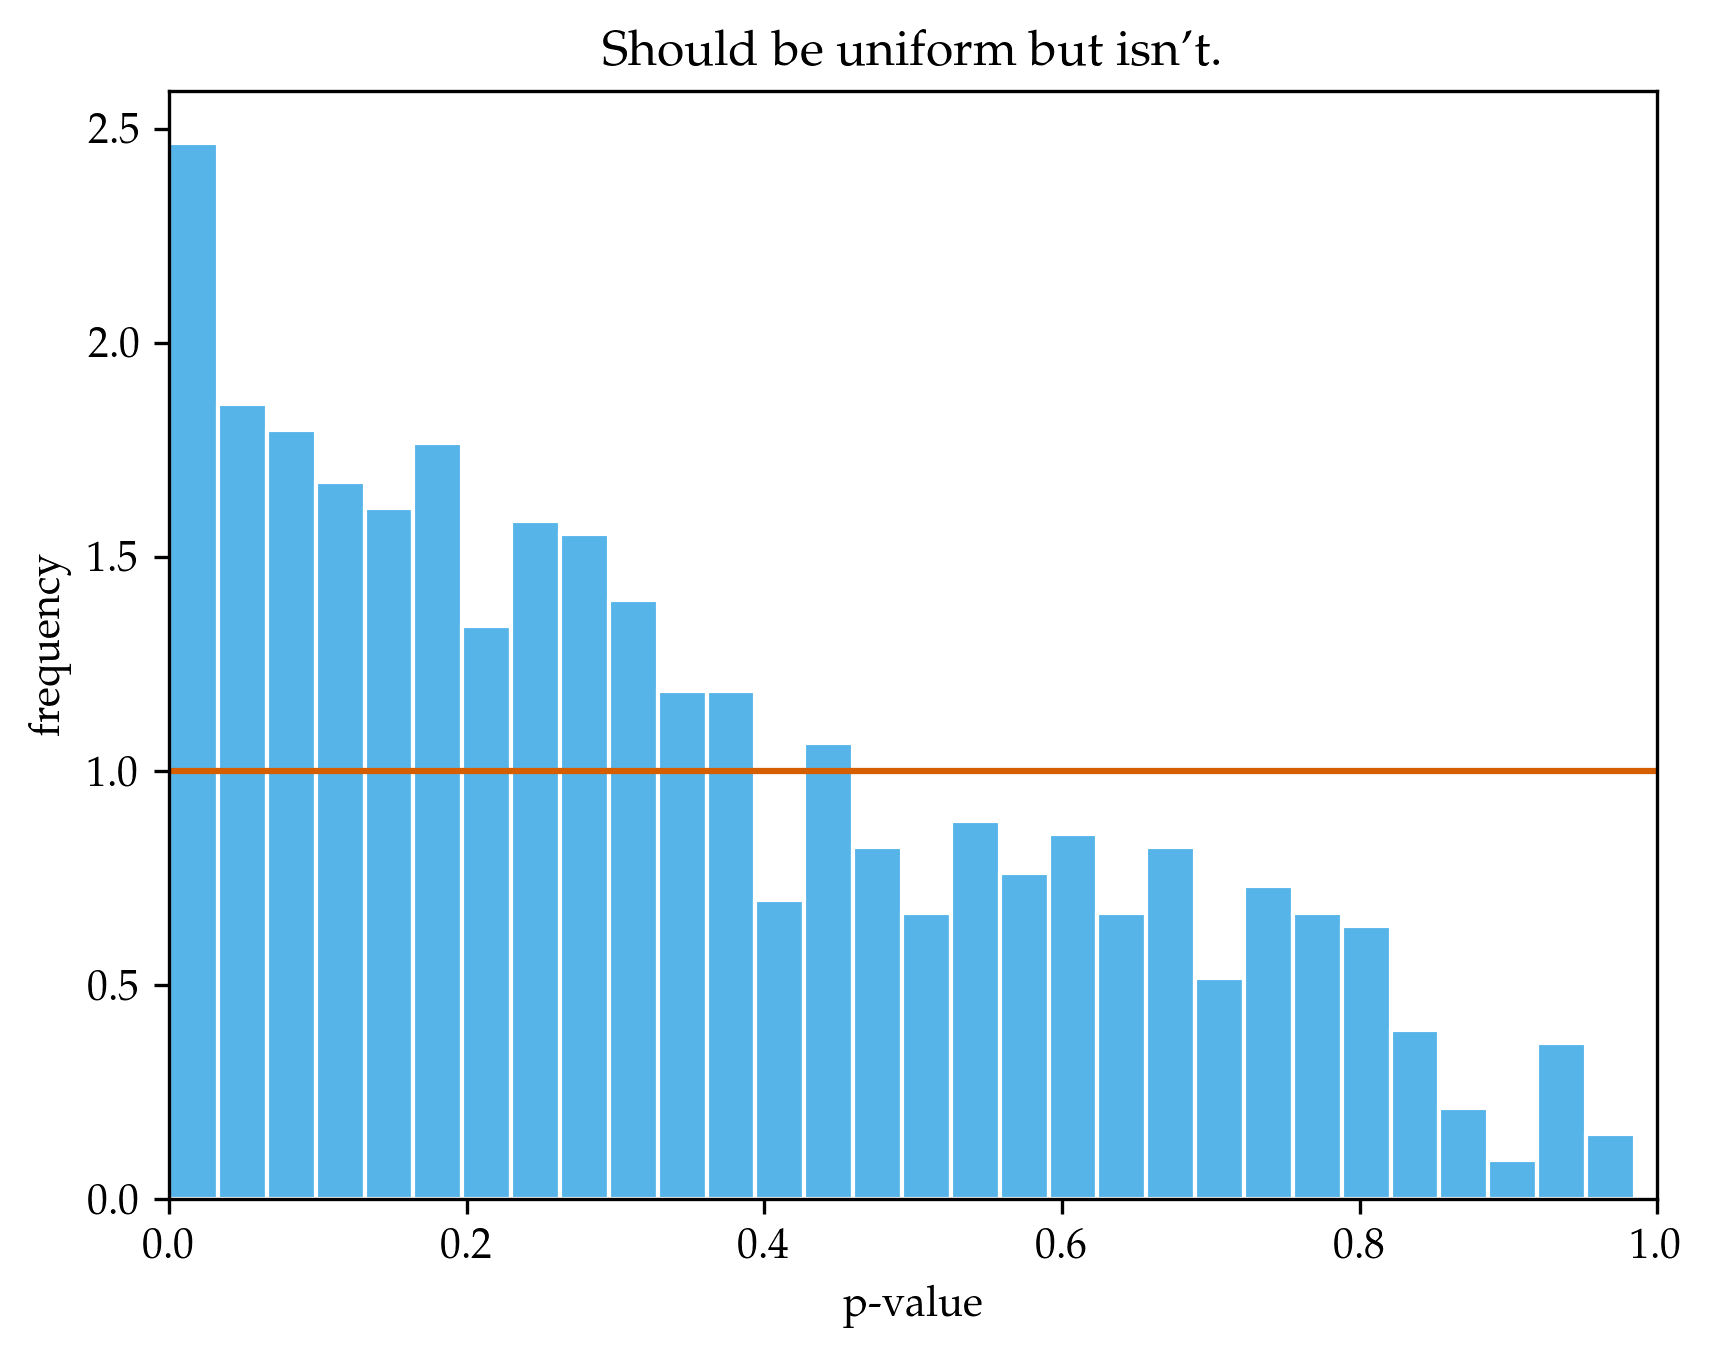

In [71]:
plt.plt[:hist](null_pvals_KS, bins=30, color=cbbPalette[2], normed=true, edgecolor="white")
plt.axhline(1.0, color=cbbPalette[6])
plt.xlabel("p-value")
plt.ylabel("frequency")
plt.title("Should be uniform but isn't.")
plt.xlim(0, 1)
;

In [72]:
@time null_pvals_KS_2 = [
    KS.sim_deconv(
        Normal(0.0, 2.0), Normal(0.0, 2.0),
        Gamma(2.0, 1.0), Gamma(2.0, 2.0), 
        n_X, n_Y, t_KS; 
        niter=200
        ) 
    for _ in 1:1000]
;

296.836368 seconds (21.14 M allocations: 10.962 GiB, 0.68% gc time)


Previously

    490.908203 seconds (20.87 M allocations: 10.636 GiB, 0.36% gc time)

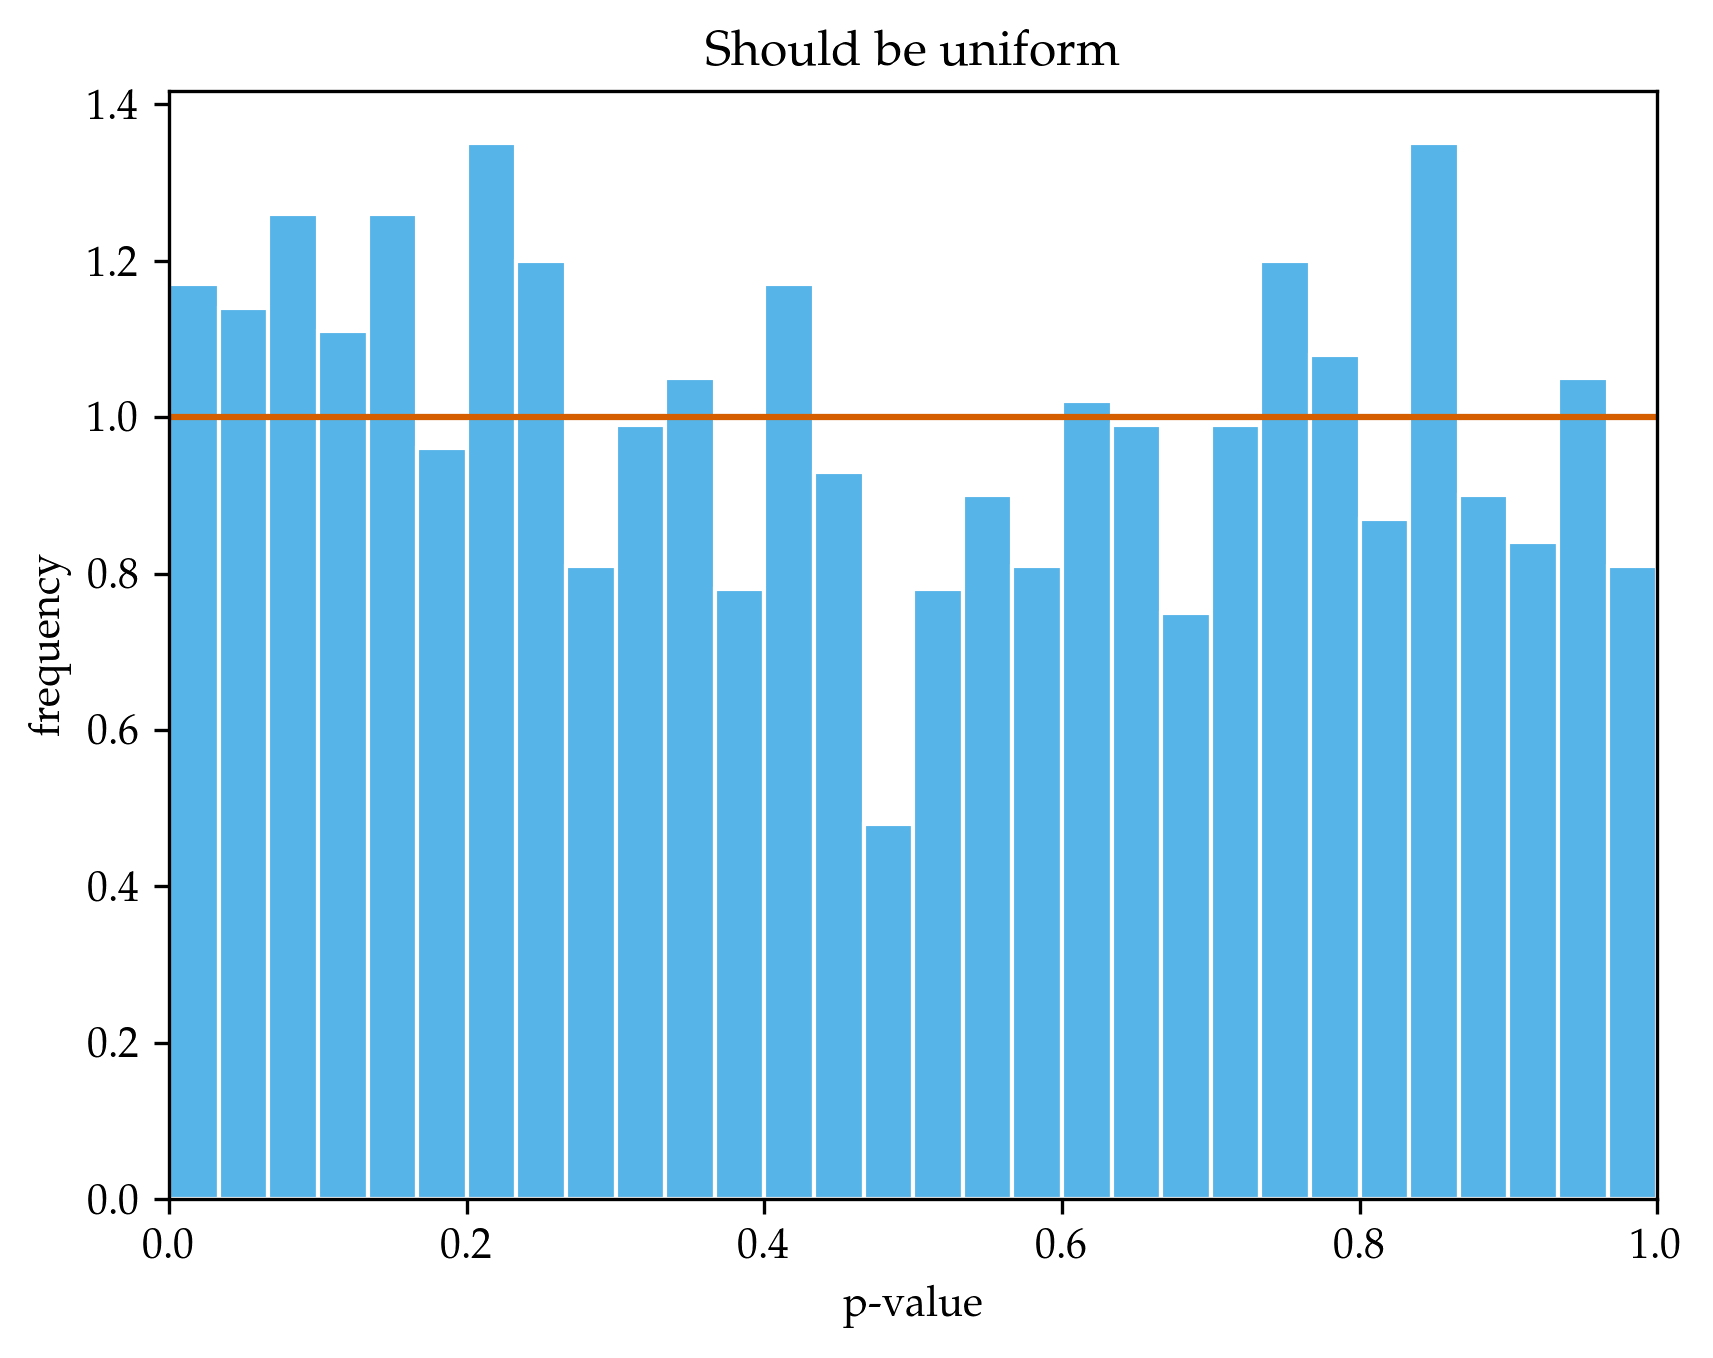

In [73]:
plt.plt[:hist](null_pvals_KS_2, bins=30, color=cbbPalette[2], normed=true, edgecolor="white")
plt.axhline(1.0, color=cbbPalette[6])
plt.xlabel("p-value")
plt.ylabel("frequency")
plt.title("Should be uniform")
plt.xlim(0, 1)
;

In [31]:
@time alt_pvals_KS = [
    KS.sim_deconv(
        Normal(0.0, 2.0), Normal(1.0, 2.0),
        Gamma(2.0, 1.0), Gamma(2.0, 2.0), 
        n_X, n_Y, t_KS; 
        niter=400
        ) 
    for _ in 1:400]
;

203.133303 seconds (16.28 M allocations: 8.452 GiB, 0.72% gc time)


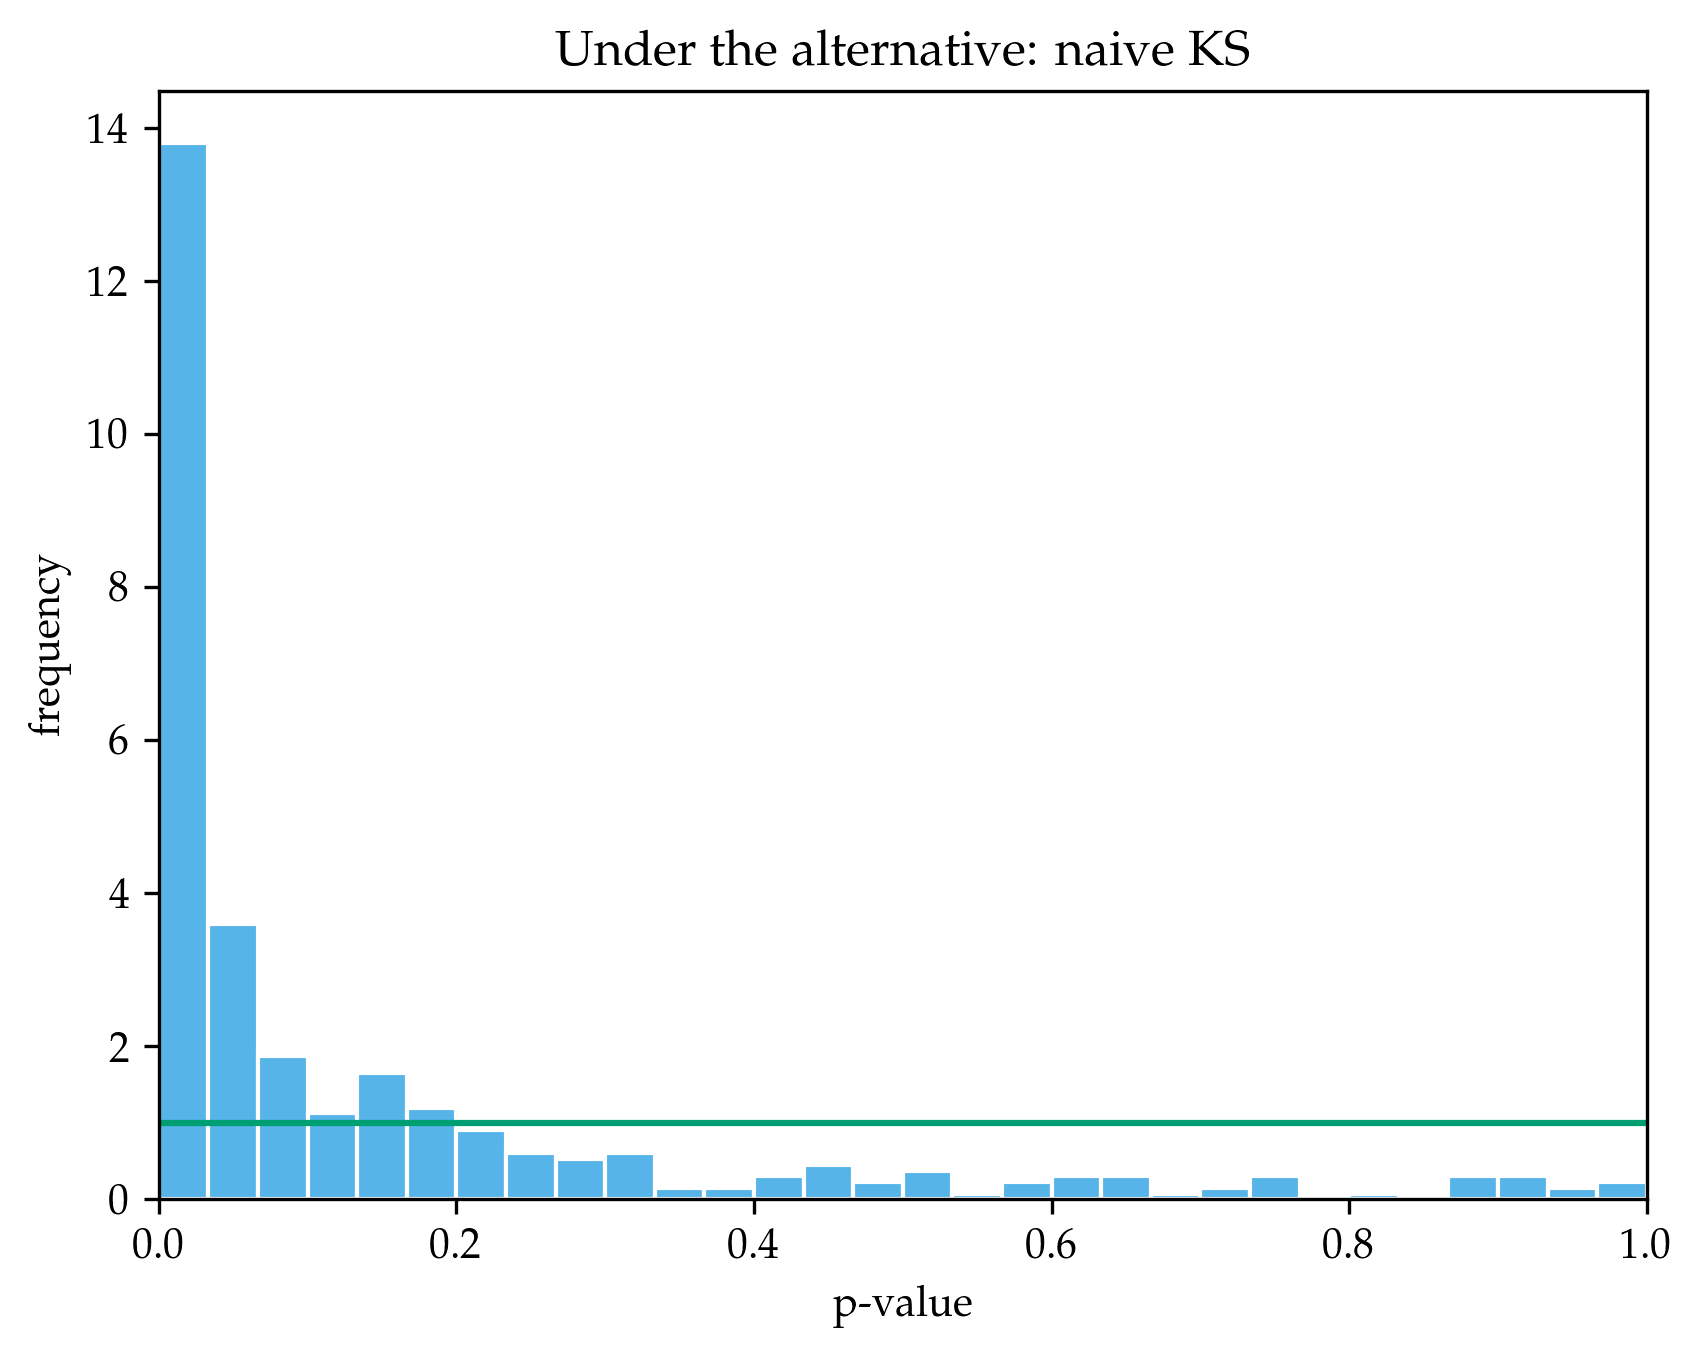

In [48]:
plt.plt[:hist](alt_pvals_KS, bins=30, color=cbbPalette[2], normed=true, edgecolor="white")
plt.axhline(1.0, color=cbbPalette[3])
plt.xlabel("p-value")
plt.ylabel("frequency")
plt.title("Under the alternative: naive KS")
plt.xlim(0, 1)
;

In [33]:
@time null_pvals_L1 = let
    n_X = 100
    n_Y = 150
    p = 1.0
    bw = 0.3
    xgrid = collect(linspace(-10.0, 10.0, 1000))
    t_Lp = KS.distance_test_statistic(p, bw, xgrid)
    pvals = [
        KS.sim_deconv( # perform a single simulation
            Normal(0.0, 2.0), Normal(0.0, 2.0),
            Gamma(2.0, 1.0), Gamma(2.0, 2.0), 
            n_X, n_Y, t_Lp; 
            niter=100 # number of *bootstrap* samples
            ) 
        for _ in 1:200]
    pvals
end
;

6808.769595 seconds (23.20 M allocations: 3.056 GiB, 0.01% gc time)


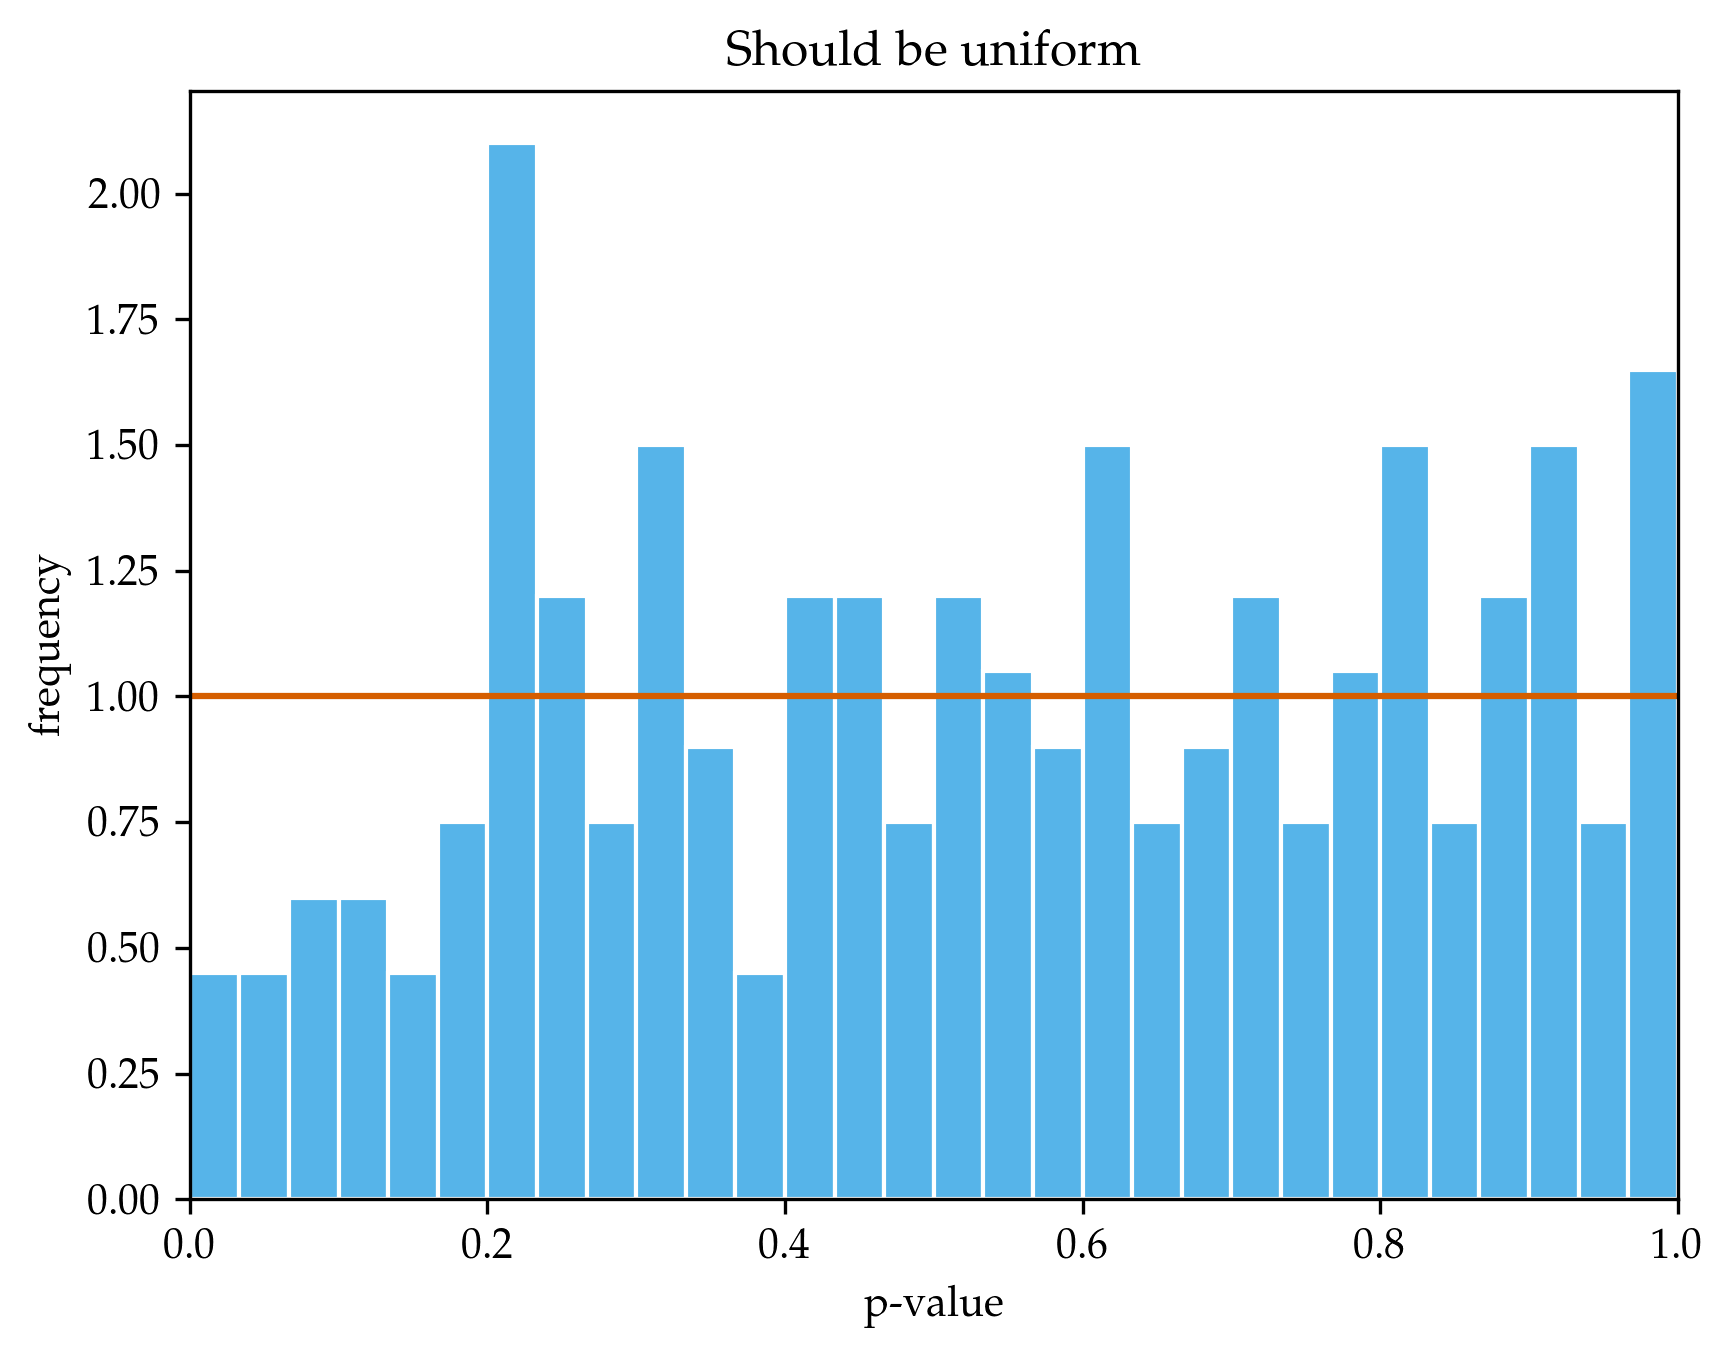

In [34]:
plt.plt[:hist](null_pvals_L1, bins=30, color=cbbPalette[2], normed=true, edgecolor="white")
plt.axhline(1.0, color=cbbPalette[6])
plt.xlabel("p-value")
plt.ylabel("frequency")
plt.title("Should be uniform")
plt.xlim(0, 1)
;

In [35]:
@time alt_pvals_L1 = let
    n_X = 100
    n_Y = 150
    p = 1.0
    bw = 0.3
    xgrid = collect(linspace(-10.0, 10.0, 1000))
    t_Lp = KS.distance_test_statistic(p, bw, xgrid)
    pvals = [
        KS.sim_deconv( # perform a single simulation
            Normal(0.0, 2.0), Normal(1.0, 2.0),
            Gamma(2.0, 1.0), Gamma(2.0, 2.0), 
            n_X, n_Y, t_Lp; 
            niter=100 # number of *bootstrap* samples
            ) 
        for _ in 1:200]
    pvals
end
;

6750.519069 seconds (23.17 M allocations: 3.053 GiB, 0.01% gc time)


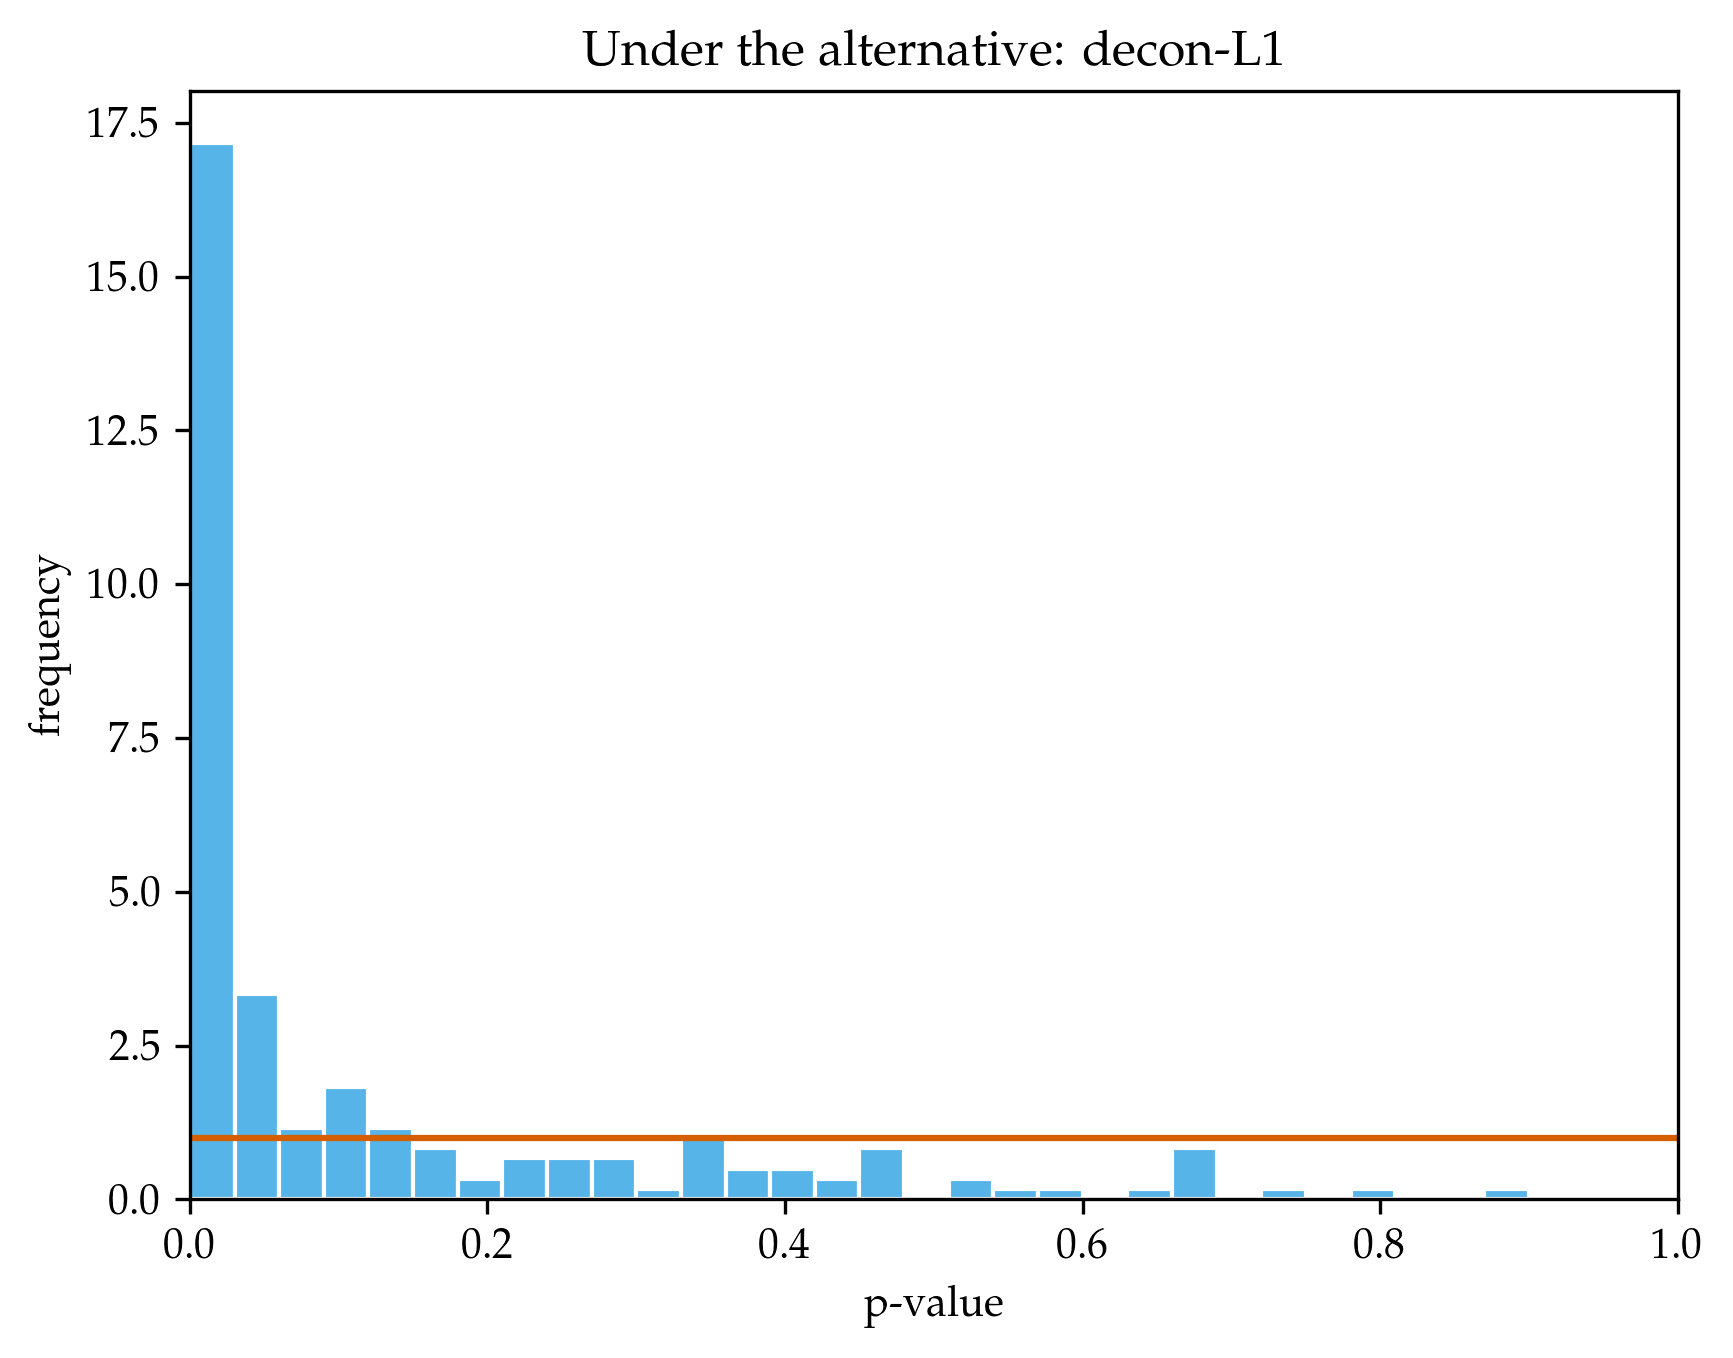

In [37]:
plt.plt[:hist](alt_pvals_L1, bins=30, color=cbbPalette[2], normed=true, edgecolor="white")
plt.axhline(1.0, color=cbbPalette[6])
plt.xlabel("p-value")
plt.ylabel("frequency")
plt.title("Under the alternative: decon-L1")
plt.xlim(0, 1)
;